# Determining the effects of marketing investment on sales using Bayesian time series models: CasualImpact package 


When marketers invest in a campaign, it's essential that they are able to demonstrate that their investment has actually fulfilled its purpose. It is often very easy to confuse causation with correlation, and with marketing investment this remains true. Typically, causation would be determined in a controlled experiment: for this example, the researchers would have performed the marketing investment in some cases but not others, and then compared the results in revenue between the experimental and control groups. However, in many cases, this is not possible, and a Bayesian time series analysis is needed to find causation. What the bayesian time series analysis attempts to predict is what would have happened with our data had there not been an intervention (in this case the marketing investment). In technical terms, this is labeled the counterfactual. If the counterfactural can be predicted with sufficient levels of confidence, then we can measure the effects of the intervention by comparing the counterfactual and what was actually observed. 





# 1 Loading packages and dataset)


In [1]:
# load required packages
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(xts)
library(CausalImpact)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: bsts
Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart



In [2]:
# get the file name
list.files(path = "../input")

[1] "Features data set.csv" "sales data-set.csv"    "stores data-set.csv"

In [3]:
# import data
sales_df <- read_csv("../input/sales data-set.csv")

Parsed with column specification:
cols(
  Store = col_double(),
  Dept = col_double(),
  Date = col_character(),
  Weekly_Sales = col_double(),
  IsHoliday = col_logical()
)


In [4]:
# quick look at the data
glimpse(sales_df)

Observations: 421,570
Variables: 5
$ Store        <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Dept         <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Date         <chr> "05/02/2010", "12/02/2010", "19/02/2010", "26/02/2010"...
$ Weekly_Sales <dbl> 24924.50, 46039.49, 41595.55, 19403.54, 21827.90, 2104...
$ IsHoliday    <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE,...


In [5]:
# change variables to appropriate type
sales_df <-
  sales_df %>%
  mutate(Store = as.factor(Store),
         Dept = as.factor(Dept),
         Date = as.Date(Date, "%d/%m/%Y"))

glimpse(sales_df)
levels(sales_df$Store)
levels(sales_df$Dept)

Observations: 421,570
Variables: 5
$ Store        <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Dept         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Date         <date> 2010-02-05, 2010-02-12, 2010-02-19, 2010-02-26, 2010-...
$ Weekly_Sales <dbl> 24924.50, 46039.49, 41595.55, 19403.54, 21827.90, 2104...
$ IsHoliday    <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE,...


[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35" "36" "37" "38" "39" "40" "41" "42" "43" "44" "45"

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "16"
[16] "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30" "31"
[31] "32" "33" "34" "35" "36" "37" "38" "39" "40" "41" "42" "43" "44" "45" "46"
[46] "47" "48" "49" "50" "51" "52" "54" "55" "56" "58" "59" "60" "65" "67" "71"
[61] "72" "74" "77" "78" "79" "80" "81" "82" "83" "85" "87" "90" "91" "92" "93"
[76] "94" "95" "96" "97" "98" "99"

2) Filter data so that there is a smaller, more usable amount to work with:

In [6]:
sales_trimmed <-
  sales_df %>%
  filter(Store == 1,
         Dept == 1 | Dept == 2 | Dept == 3 | Dept == 4) %>%
  dplyr::select(-IsHoliday)

glimpse(sales_trimmed)

Observations: 572
Variables: 4
$ Store        <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Dept         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Date         <date> 2010-02-05, 2010-02-12, 2010-02-19, 2010-02-26, 2010-...
$ Weekly_Sales <dbl> 24924.50, 46039.49, 41595.55, 19403.54, 21827.90, 2104...


After the data is cleaned we can visualize it:

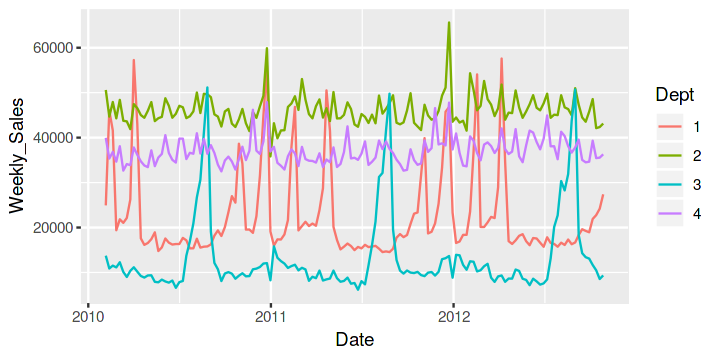

In [7]:
# plot data
options(repr.plot.width=6, repr.plot.height=3)

ggplot(sales_trimmed, aes(x = Date, y = Weekly_Sales, colour = Dept)) +
  geom_line()

Analysis: Department 3 had a sales spike during the end of the summer; department 1 has a few intermittent sales peaks; department 2 peaks around Christmas and department 4 slightly more even throughout the year. 

# Prepping data for analysis: 

Created an example dataset as the input for our causal inference analysis. Started by trimming the time period and then altering some of the values to create an effect from our hypothetical marketing investment. Lastly, we got the dataframe into the correct format for the CausalImpact analysis. 


In [8]:
# trim by date and create marketing campaign variable
sales_marketing <-
  sales_trimmed %>%
  filter(Date > "2010-06-01",
         Date < "2012-06-01") %>%
  mutate(marketing_campaign = ifelse(Dept == 4 & Date > "2012-02-28" & Date < "2012-04-01", 
                                    TRUE, FALSE))

In [9]:
# check marketing campaign variable
sales_marketing %>%
  filter(Date > "2012-02-01" & Date < "2012-05-01",
         Dept == 1 | Dept == 4)

Store,Dept,Date,Weekly_Sales,marketing_campaign
1,1,2012-02-03,23510.49,FALSE
1,1,2012-02-10,36988.49,FALSE
1,1,2012-02-17,54060.10,FALSE
1,1,2012-02-24,20124.22,FALSE
1,1,2012-03-02,20113.03,FALSE
1,1,2012-03-09,21140.07,FALSE
1,1,2012-03-16,22366.88,FALSE
1,1,2012-03-23,22107.70,FALSE
1,1,2012-03-30,28952.86,FALSE
1,1,2012-04-06,57592.12,FALSE


In this hypothetical investment campaign, department 5 received the investment that runs during March 2012. Next we created the test dataset by altering the Weekly_sales when the investment campaign was running. 

In [10]:
# create adjusted sales variable - 30% increase in weekly sales
sales_adj <-
  sales_marketing %>%
  mutate(adj_sales = ifelse(marketing_campaign == TRUE, 
                            Weekly_Sales * 1.3, 
                            Weekly_Sales))

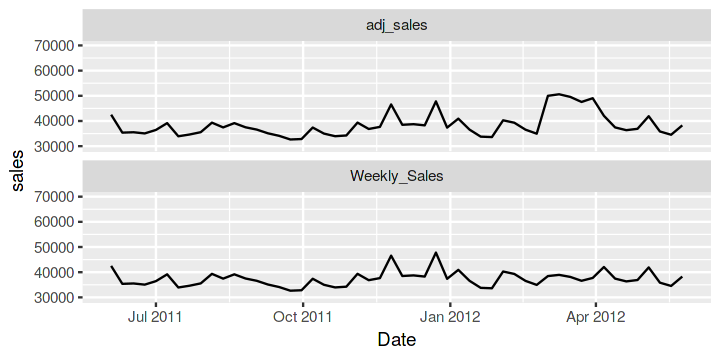

In [11]:
# plot adjusted weekly sales against original data
sales_adj %>%
  filter(Dept == 4 & Date > "2011-06-01") %>%
  dplyr::select(Date, Weekly_Sales, adj_sales) %>%
  gather(type, sales, -Date) %>%
  ggplot(aes(x = Date, y = sales)) +
    geom_line() +
  ylim(30000, 70000) +
  facet_wrap(~type, ncol = 1)

Furthering data preparation: 


The 'CausalImpact()' function requires that we changed the data from a 'long' format to a 'wide' dataframe (which is one colump per department). 


In [12]:
# create wide dataframe
marketing_cause <-
  sales_adj %>%
  dplyr::select(Date, Dept, adj_sales) %>%
  spread(Dept, adj_sales) %>%
  rename(dept1 = 2, 
         dept2 = 3,
         dept3 = 4,
         dept4 = 5) %>%
  dplyr::select(Date, dept4, dept1, dept2, dept3)

head(marketing_cause)

Date,dept4,dept1,dept2,dept3
2010-06-04,40548.19,17558.09,48754.47,8001.41
2010-06-11,36579.96,16637.62,47089.54,7742.75
2010-06-18,35059.52,16216.27,44428.71,8201.06
2010-06-25,34454.69,16328.72,45299.92,6591.22
2010-07-02,39773.71,16333.14,47077.72,7857.88
2010-07-09,39781.45,17688.76,46752.12,8112.67


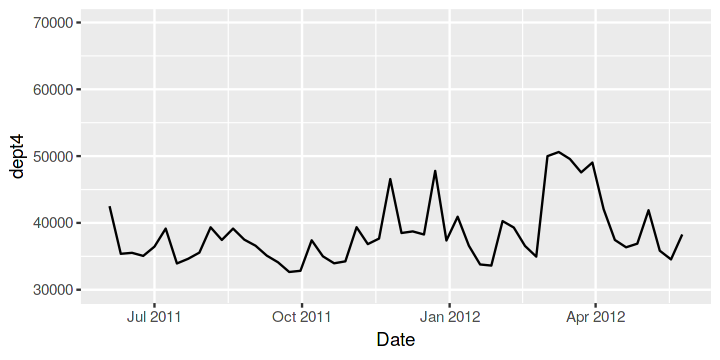

In [13]:
marketing_cause %>%
  filter(Date > "2011-06-01") %>%
  ggplot(aes(x = Date, y = dept4)) +
    geom_line() +
  ylim(30000, 70000)



Created an `xts` time series and dropped the date column but used it to order our `xts` time series.

              dept4    dept1    dept2   dept3
2010-06-04 40548.19 17558.09 48754.47 8001.41
2010-06-11 36579.96 16637.62 47089.54 7742.75
2010-06-18 35059.52 16216.27 44428.71 8201.06
2010-06-25 34454.69 16328.72 45299.92 6591.22
2010-07-02 39773.71 16333.14 47077.72 7857.88
2010-07-09 39781.45 17688.76 46752.12 8112.67

              dept4    dept1    dept2    dept3
2012-04-20 36350.03 16976.19 45561.85  8647.36
2012-04-27 36894.54 16347.60 45456.23  8635.62
2012-05-04 41897.55 17147.44 50501.30 10655.35
2012-05-11 35840.06 18164.20 46717.76 10342.72
2012-05-18 34536.29 18517.79 44411.23  8609.82
2012-05-25 38270.34 16963.55 45817.07  8345.33

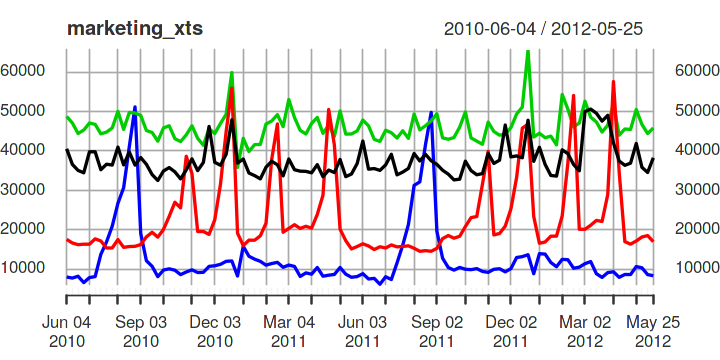

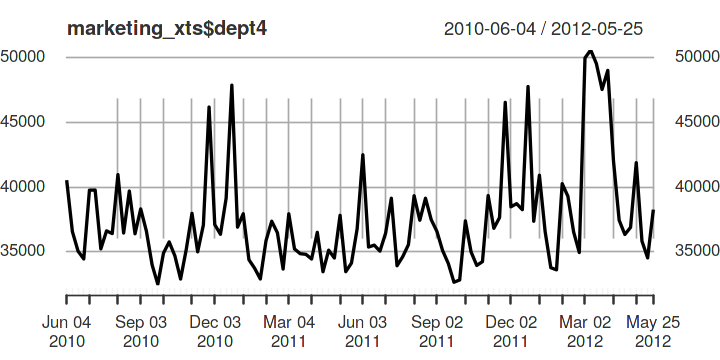

In [14]:
# convert dataframe to xts time series
marketing_xts <-
  marketing_cause %>%
  dplyr::select(-Date) %>%
  as.xts(order.by = marketing_cause$Date)

head(marketing_xts)
tail(marketing_xts)
plot(marketing_xts)
plot(marketing_xts$dept4)

# Setting up the causal inference model

When the data was in the correct format we needed to tell our model when the marketing campaign happened by specifying pre and post periods. 

In [15]:
# create pre and post periods
pre_period <- as.Date(c("2010-06-04", "2012-02-29"))
post_period <- as.Date(c("2012-03-01", "2012-03-31"))

Preliminary causal inference analysis:

In [16]:
# perform Bayesian structural time series analysis for causal inference
marketing_causal <- CausalImpact(marketing_xts, 
                             pre.period = pre_period, 
                             post.period = post_period)

Posterior inference {CausalImpact}

                         Average          Cumulative     
Actual                   49355            246773         
Prediction (s.d.)        37813 (1025)     189066 (5127)  
95% CI                   [35879, 4e+04]   [179397, 2e+05]
                                                         
Absolute effect (s.d.)   11541 (1025)     57707 (5127)   
95% CI                   [9534, 13475]    [47669, 67375] 
                                                         
Relative effect (s.d.)   31% (2.7%)       31% (2.7%)     
95% CI                   [25%, 36%]       [25%, 36%]     

Posterior tail-area probability p:   0.00113
Posterior prob. of a causal effect:  99.88662%

For more details, type: summary(impact, "report")



Warning message:
“Removed 104 rows containing missing values (geom_path).”

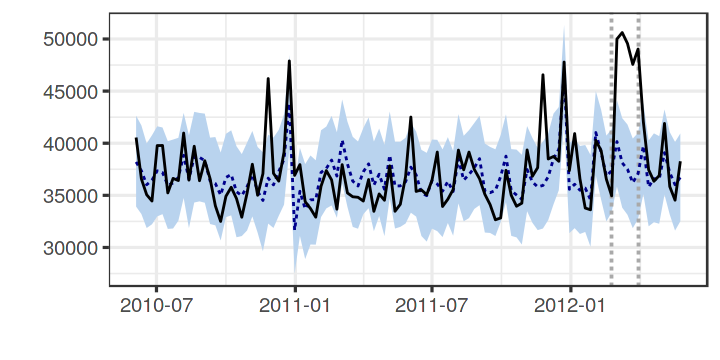

In [17]:
# summary report of model and plot
summary(marketing_causal)
plot(marketing_causal, "original")

This result was decent, as the summary output predicts an effect of 31%. This was a good prediction as the artificial marketing campaign we created caused a 30% increase in output.  The p value is very small, and the 95% confidence interval ranges from 25% to 36%, which is a satisfactory interval. In this case, we were confident that the marketing campaign made a positive difference.

Use "report" to call a report of the analysis:

In [18]:
# generate summary report
summary(marketing_causal, "report")

Analysis report {CausalImpact}


During the post-intervention period, the response variable had an average value of approx. 49.35K. By contrast, in the absence of an intervention, we would have expected an average response of 37.81K. The 95% interval of this counterfactual prediction is [35.88K, 39.82K]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 11.54K with a 95% interval of [9.53K, 13.48K]. For a discussion of the significance of this effect, see below.

Summing up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 246.77K. By contrast, had the intervention not taken place, we would have expected a sum of 189.07K. The 95% interval of this prediction is [179.40K, 199.10K].

The above results are given in terms of absolute numbers. In relative terms, the respons

# Concluding Remarks 
A potential issue with this time series is that we did not incorporate seasonality. In our case, the data was weekly, and if we were looking for annual seasonality we would have to add additional arguments. Another potential issue is some of the assumptions that were made when performing this analysis. In this example, we used the sales from departments 1, 2 and 3 as our non-interventional controls. One critical assumption is that  these are not affected by our intervention. In the real world, that might not be true. If a campaign for department 4 brings more customers into the store, would sales in other departments be affected as well? If we were to improve this project, we would build a more complicated model that includes multiple seasonalities. 
